# Acknowledgements:

I would like to thank following people for their helpful open-surce Kaggle kernels and analysis on **House Prices: Advanced Regression Techniques** dataset amd other people for asking and answering some principal questions about statistics, ML, and data in general:
* Alexandru Papiu  - [Regularized Linear Models](https://www.kaggle.com/apapiu/regularized-linear-models)
* Serigne - [Stacked Regressions : Top 4% on LeaderBoard](https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard)
* Luka Lončar - [Combo Set - The merge of train and test set](https://www.kaggle.com/questions-and-answers/40640)
* Oscar Takeshita - [What is considered to be leakage in imputation?](https://www.kaggle.com/c/titanic/discussion/37730)

# Imports

In [1]:
import pandas as pd
import numpy as np
import math, os, re
import seaborn as sns
from scipy import stats
from scipy.stats import norm, skew

# preprocessing
from sklearn.preprocessing import OneHotEncoder, StandardScaler, \
    PolynomialFeatures, Normalizer, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_regression, RFE

# postprocessing
from sklearn.metrics import mean_squared_log_error as msle, make_scorer, fbeta_score, \
    mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV, \
    cross_val_score, KFold
from sklearn.feature_selection import SelectFromModel

# visualizations
import matplotlib.pyplot as plt
import seaborn as sns
import bokeh
from IPython.display import clear_output
from bokeh.plotting import figure
from bokeh.models import HoverTool, ColumnDataSource, BoxSelectTool, Tap, Plot, \
    LinearAxis, Range1d
from bokeh.io import show, output_notebook
from bokeh.layouts import row, gridplot
from bokeh.models.glyphs import HBar
from bokeh.transform import factor_cmap

# models
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, \
    BayesianRidge, SGDRegressor, LassoCV, BayesianRidge, LassoLarsIC
from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import LinearSVR, SVR, NuSVR
from sklearn.tree import DecisionTreeRegressor, ExtraTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.ensemble import AdaBoostRegressor, BaggingRegressor, \
    GradientBoostingRegressor, RandomForestRegressor
import xgboost
import lightgbm

# Functions

In [30]:
## PLOTTING ##

#bokeh scatter plot
def plot_scatter(df, x, y):
    '''Plots bokeh scatter plot.'''
    source = ColumnDataSource(df)

    p = figure(plot_width=700, plot_height=400)
    p.circle(x, y, size=10, color="navy", alpha=0.5, source=source,
             hover_fill_color='red', selection_fill_color='red')

    p.title.text = x + ' vs '+ y
    p.xaxis.axis_label = x
    p.yaxis.axis_label = y


    hover = HoverTool(tooltips=[("Index", "$index"), ("(x,y)", "($x, $y)")])
    p.add_tools(hover, BoxSelectTool())

    # show the results
    show(p)
    
# plots feature vs target seaborn box plots 
def plot_box(df, feature, target):
    
    my_order = df.groupby(by=[feature])[target].median().sort_values(ascending=False).index
    
    plt.figure(figsize=(10, 6))
    _ = sns.boxplot(x=feature, y=target, data=df, order=my_order)
    _ = plt.title('Training data swarms', fontsize=14, weight='bold')
    _ = plt.xlabel(feature, fontsize=14)
    _ = plt.ylabel(target, fontsize=14)
    plt.show()
    
#plots histogram, PDF & CDF
def plot_hist2(df, feature, bins=50):
    '''Plots bokeh histogram, PDF & CDF of a DF feature.'''
    x = df[feature][df[feature].notna()].values # feature values
    hist, edges = np.histogram(x, bins=bins, density=True)
    mu, sigma = norm.fit(x)
    xs = np.linspace(min(x), max(x)+1, len(x))
    
    pdf = norm.pdf(xs, loc=mu, scale=sigma) #probability distribution function
    cdf = norm.cdf(xs, loc=mu, scale=sigma) #cumulative distribution function
    
    #plot histogram with PDF
    p1 = figure(title=feature)
    p1.quad(bottom=0, top=hist, left=edges[:-1], right=edges[1:],
          fill_color='royalblue', line_color='black', alpha=0.7)
    p1.line(xs, pdf, line_color='red', line_width=5, alpha=0.5, legend='PDF')
    p1.legend.location = "center_right"
    p1.y_range.start = 0
    
    #plot CDF separately since it can outscale the histogram
    p2 = figure(title=feature)
    p2.line(xs, cdf, line_color='darkgoldenrod', line_width=4, alpha=0.7, legend='CDF')
    p2.y_range.start = 0
    p2.legend.location = "center_right"
    
    show(gridplot([p1,p2], ncols=2, plot_width=350, plot_height=350))

#plots histogram, PDF & CDF on same canvas
def plot_hist(df, feature, bins=50):
    '''Plots bokeh histogram, PDF & CDF of a DF feature.'''
    x = df[feature][df[feature].notna()].values # feature values
    hist, edges = np.histogram(x, bins=bins, density=True)
    mu, sigma = norm.fit(x)
    xs = np.linspace(min(x), max(x)+1, len(x))
    
    pdf = norm.pdf(xs, loc=mu, scale=sigma) #probability distribution function
    cdf = norm.cdf(xs, loc=mu, scale=sigma) #cumulative distribution function
    
    #plot histogram with PDF and CDF
    p1 = figure(title=feature, plot_width=600, plot_height=400)
    p1.quad(bottom=0, top=hist, left=edges[:-1], right=edges[1:],
          fill_color='royalblue', line_color='black', alpha=0.7)
    p1.line(xs, pdf, line_color='red', line_width=5, alpha=0.5, legend='PDF')
    p1.y_range = Range1d(0, max(hist) + 0.05*max(hist))
    
    # Setting the second y axis range name and range
    p1.extra_y_ranges = {"cdf": Range1d(start=0, end=1.05)}
    
    #adding the second axis to the plot.  
    p1.add_layout(LinearAxis(y_range_name="cdf"), 'right')
    
    #add cdf with y range on the right
    p1.line(xs, cdf, line_color='darkgoldenrod', line_width=4, alpha=0.8, legend='CDF',
            y_range_name='cdf')
    p1.legend.location = "center_right"
    
    show(p1)    
    
# plots two bokeh histograms on same canvas
def plot_histograms(dfs, column, bins=50):
    # find joint max range of two dataframes
    max0 = max([dfs[0][column].max(), dfs[1][column].max()]) 
    min0 = min([dfs[0][column].min(), dfs[1][column].min()])
    
    # creating numpys histograms in the background so it
    # divides the data into bins and returns bin edges
    hist1, edges1 = np.histogram(dfs[0][column], bins=bins, range=[min0,max0])
    hist2, edges2 = np.histogram(dfs[1][column], bins=bins, range=[min0,max0])
    
    # calculating value for separating two histogram
    # bins side by side
    step = (edges1[1]-edges1[0]) * 0.5
    
    # create a blank figure
    p = figure(plot_height = 300, plot_width = 400, 
               title = column)
    
    # Add a quad glyph
    p.quad(bottom=0, top=hist1, 
           left=edges1[:-1], right=edges1[1:]-step, 
           fill_color='blue', line_color='black', legend='train')
    p.quad(bottom=0, top=hist2, 
           left=edges2[:-1]+step, right=edges2[1:], 
           fill_color='green', line_color='black', legend='test')
    p.legend.location = "top_right"
    
    show(p)

In [31]:
## EDA ##

#plots boxplots if categorical, histogram if continuous feature
def inspect_feature(dfs, feature, target, names=['train', 'test'], bins=50):
    ''''''
    clear_output()
    assert feature in dfs[0].all() and feature in dfs[1].all(), \
        "{} not in both DataFrames".format(feature)
    
    #info about NaN values:
    print("'{}':\n{} NaN-s: {}".format(feature, names[0], dfs[0][feature].isna().sum()))
    print("{}  NaN-s: {}\n".format(names[1], dfs[1][feature].isna().sum()))
    
    #determine if feature is categorical or continuous
    #based on the number of unique values per feature
    n_uniques = len(dfs[0][feature].unique())
    if dfs[0][feature].dtype == 'O' or n_uniques < 20:
        # compare value counts of the feature in a single DF
        vc_df1 = dfs[0][feature].value_counts().to_frame(name=names[0])
        vc_df2 = dfs[1][feature].value_counts().to_frame(name=names[1])
        print(pd.concat([vc_df1, vc_df2], axis='columns', sort=False)
              .sort_values(by=names[0], axis=0, ascending=False))
        # plot training df box plots vs target
        plot_box(dfs[0], feature, target)
    else:
        #if feature is continuous a histogram of 
        #the training and test set data is plotted on the same canvas
        data = pd.concat([dfs[0].drop(target, axis='columns'), dfs[1]], axis='rows')
        plot_hist(df=data, feature=feature, bins=bins)  

#iterator fnction for categorizing features
def categorize_features(dfs, target, names=['train', 'test'], bins=50):
    '''Grouping features into discrete, continuous or dropping lists.
        Returns: list of discrete, continuous & dropped features'''
    discretes = []
    continuous = []
    drop = []
    def wrapper():
        '''Wrapper function for automating feature inspection and categorizaton.'''
        for f in dfs[0]:
            if f == target:
                clear_output()
                break
            inspect_feature(dfs, f, target, names=names, bins=bins)
            inp = input()
            if inp == 'd':
                yield discretes.append(f)
            elif inp == 'c':
                yield continuous.append(f)
            elif inp == 'x':
                yield drop.append(f)
            else:
                break
                
    
    for gen in wrapper():
        gen
    return discretes, continuous, drop

# General

* **Goal**: Need to predict house prices - a **offline supervised regression** task
* **Performance Measure**: *Root Mean Squared Logarithmic Error*

$$\text{RMSLE}(y, \hat{y}) = \sqrt{\frac{1}{n_\text{s}} \sum_{i=0}^{n_\text{s} - 1} (\ln (1 + y_i) - \ln (1 + \hat{y}_i) )^2},$$
$y_i$ - *true value* <br>
$\hat{y}_i$ - *prediction* <br>
$n_\text{s}$ - *number* of samples

* **Human expertice**: *Medium* - logical assumptions on data preprocessing are enough
* **Assumptions**:
    * There are **4** outliers in the training set that can be removed (based on data instructor recommendation [source](http://jse.amstat.org/v19n3/decock.pdf))
    * We can combine train and test sets for these preprocessing steps:
        * **Label encoding** (There might be classes not represented in either of the sets, thus making both sets aware of these possible classes)
        * **Imputation** (Taking median/average/most frequent values from all of the data)
        * **Standardization / Scaling** (Since actual test labels are not provided for Kaggle competitions this is not information leakage*)
    * Houses in the same neighborhood are simialar (taking the mean/median of the same neihborhood house features is a better estimate than of the whole dataset)
    * Features which calss imbalances are very high (99%) carry no useful information and can be **dropped**.
* **Miscellaneous**:
    * **Small** dataset - train, test sets **1500** observations and **80** features

## Loading Data

In [4]:
data_path = 'data/iowa_house_prices/'
train = pd.read_csv(data_path + 'train.csv', header=0)
test = pd.read_csv(data_path + 'test.csv', header=0)

print('Train set shape: {}'.format(train.shape))
print('Test set shape: {}'.format(test.shape))

Train set shape: (1460, 81)
Test set shape: (1459, 80)


## Removing Outliers
* As explained in the assumptions paragraph, we will remove 4 data points from the training since dataset instructor suggested it. To see why we do that, let's plot SalePrice vs GrLivArea where the outliers become evident
* It is suggetsed to remove all data points that have above grade square feet > 4000

In [5]:
output_notebook()

Loading BokehJS ...

In [13]:
plot_scatter(train, 'GrLivArea', 'SalePrice')

In [6]:
#removing datapoints where 'GrLivArea' > 4000 square feet
train_outl_removed = train[train.GrLivArea < 4000]

print('Train with outliers shape: {}'.format(train.shape))
print('Train without outliers shape: {}'.format(train_outl_removed.shape))

Train with outliers shape: (1460, 81)
Train without outliers shape: (1456, 81)


## Target
* Extracting target values

In [7]:
y = train_outl_removed.SalePrice.values
y.shape

(1456,)

## Combine Train & Test Sets

In [8]:
# data train & test cutoff
n_cutoff = train_outl_removed.shape[0]

# concating train & test sets into single dataframe
data = pd.concat([train_outl_removed.drop('SalePrice', axis='columns'), test], 
                 axis='rows')
data.shape

(2915, 80)

# EDA

## Categorizing Features
* With a help of pre-witten functions we examine feature:
    * Distributions if it is continuous - histograms
    * Class distributions if categorical - box plots

In [32]:
#initial examining and appending features into 3
#categories: discrete-, continuous-, and dropping features
discrete_f, continuous_f, drop_f = categorize_features([train_outl_removed, test], 'SalePrice')

In [33]:
print(discrete_f)

['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'RoofStyle', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageCars', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MoSold', 'YrSold', 'SaleType', 'SaleCondition']


In [34]:
print(continuous_f)

['LotFrontage', 'LotArea', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'GarageYrBlt', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch']


In [35]:
print(drop_f)

['Id', 'Utilities', 'RoofMatl', 'PoolArea', 'MiscFeature', 'MiscVal']


In [ ]:
## Discrete ##

cat_imp = ['MSSubClass', ]

nans_to_no = ['Alley', 'MasVnrType', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
              'BsmtFinType1', 'BsmtFinType2', 'FireplaceQu', 'GarageType',
              'GarageFinish', 'GarageQual', 'GarageCond', 'Fence']

ordinals = ['MSZoning', 'Street', 'LandContour', 'Neighborhood', 'BldgType',
            'OverallQual','ExterQual', 'ExterCond', 'MasVnrType', 'Foundation', 
            'BsmtQual','BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'Heating', 
            'HeatingQC', 'CentralAir', 'Electrical', 'BsmtFullBath', 'FullBath'
            'KitchenQual', 'TotRmsAbvGrd', 'Fireplaces', 'FireplaceQu',
            'GarageType', 'GarageFinish', 'GarageCars', 'GarageQual', 'GarageCond',
            'PavedDrive', 'PoolQC', 'SaleType', 'SaleCondition']



ordinals?? = ['Alley', 'Condition1', 'Condition2']

## Numeric ##
nans_to_0 = ['MasVnrArea', 'GarageYrBlt',]

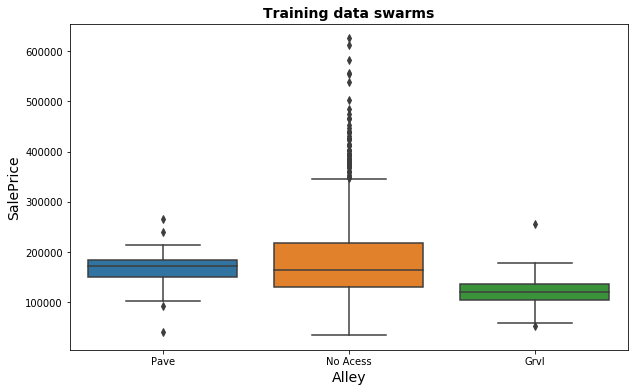

In [56]:
train_eda = train_outl_removed.copy()
train_eda['Alley'] = train_eda.Alley.replace(np.nan, 'No Acess')

plot_box(train_eda, 'Alley', 'SalePrice')

In [42]:
train_eda = train_outl_removed[train_outl_removed['Alley']].replace(np.nan, 'No Acess')
plot_box(train_eda, 'Alley', 'SalePrice')            

ValueError: cannot index with vector containing NA / NaN values

* **LotFrontage** NaN-s can be averaged by it's neighborhood **median** 'LotFrontage' value since their values are probably similar
* **Utilities** is not informative since only one observation is other than the main class. It can be easily removed. 
* **Alley** Examine Box-Plot with NaN-s as "no alley access"
* **Condition1** and **Condition2** Consider reclassifing PosN/PosA, normal, and railroad together. It can be ordinal
* **BldgType** Consider reclassifiyng Twnhs,Duplex and 2fmCon together into one class since these have low variance and smaller median house value. Possibly ordinal
* **OverallCond** Reclassify the ratings (1,2 ; 3,4 ; 6,7,8 ; 5 ; 9)
* **YearBuilt** Rebin by examining SalePrice vs YearBuilt of trainign data
* **YearRemodAdd** Rebin by examining SalePrice vs YearRemodAdd of training data
* **RoofMatl** Drop the data - classes are too skewed and the main class has very high variance
* **ExterCond** Ordinal (Po, Fa, TA, Gd, Ex)
* **BsmtQual**, **BsmtCond**, **BsmtExposure**, **BsmtFinType1**: Ordinals - start , **GarageFinish**, labels with "no basement"
* **Heating** Floor into Grav and ordinal
* **Electrical** Mix to FuseP, inspect missing train value
* **LowQualFinSF** Maybe dropping alltogether
* **BsmtFullBath** Determine if missing values in test set are equivalent to no basement
* **TotRmsAbvGrd** Reclassify 12>= into 12
* **GarageYrBlt** Rebin the years, no garage == 0 will be in seprate bin, typo in year 2200 to 2002
* **GarageCars** Reclassify: 4 >= 4 ordinal, inspect missing value
* **GarageArea** Inspect missign value
* **GarageQual** Ex to TA
* **GarageCond** Ex to Gd
* **PoolQC** All NaN-s to 0 and other 1

In [ ]:
#inspecting missing 'Electrical' value in train data
print(data[data.Electrical.isna()])

In [ ]:
#inspecting 'LowQualFinSF' values > 0
train_outl_removedtl_removed[train_outl_removed['LowQualFinSF']]

In [ ]:
#inspect the mistaken 'GarageYrBlt' value
data[data['GarageYrBlt'] > 2020]

In [ ]:
#inspect missing value in 'GarageCars'
data[data['GarageCars'].isna()]

In [ ]:
#inspect missing value in 'GarageArea'
data[data['GarageArea'].isna()]

# Functions

**EDA & Plotting**

In [7]:
# function to automate EDA through a generator
def yielder(dfs, target):

    def wrapper():
        for f in dfs[0]:
            if f == target:
                clear_output()
                break
            compare_features(dfs, f, target)
            inp = input()
            if inp == '':
                yield f
            else:
                break
                
    for gen in wrapper():
        gen

In [9]:
# plots feature vs target with 1st & 2nd order correlation
# coeficients and fits
def feature_pearson(df, feature, target):
    clear_output() # clear stdout 
    r_value1 = stats.pearsonr(df[feature], df[target]) # calculate Pearson corr coef
    r_value2 = stats.pearsonr(df[feature]**2, df[target])
    
    if abs(r_value2[0]) > abs(r_value1[0]): 
    # plot y(x) with regression line and uncertainty area
        plt.figure(figsize=(10, 6))
        sns.regplot(x=feature, y=target, data=df, line_kws={'color':'red','label':'order 1'})
        sns.regplot(x=feature, y=target, data=df, order=2, label='order 2', color='green', scatter=None)
        plt.title('{} r_1={:.2f}, r_2={:.2f}'.format(feature, r_value1[0], r_value2[0]), fontsize=14, weight='bold')
        plt.xlabel(feature, fontsize=14)
        plt.ylabel(target, fontsize=14)
        plt.legend()
        plt.show()
    else:
        plt.figure(figsize=(10, 6))
        sns.regplot(x=feature, y=target, data=df, line_kws={'color':'red','label':'order 1'})
        plt.title('{} r_1={:.2f}'.format(feature, r_value1[0]), fontsize=14, weight='bold')
        plt.xlabel(feature, fontsize=14)
        plt.ylabel(target, fontsize=14)
        plt.legend()
        plt.show()

In [10]:
# checks wether training and testing sets were equally trasnformed
def assert_dfs(df1, df2, names=['Train', 'Test']):
    
    assert df1.columns.all() == df2.columns.all(), \
    "DF-s column names do not match!"

    print('{} shape: {}'.format(names[0], df1.shape))
    print('{} shape: {}'.format(names[1], df2.shape))

In [15]:
def preds_to_csv(estimator, X_train, X_test, y, log_y=False):
    # train the model and get predictions
    reg_model = estimator.fit(X=X_train, y=y)
    predictions = reg_model.predict(X_test) 
    
    if log_y == True:
        predictions = np.exp(predictions)-1
    
    # predictions to a DF
    submission_df = pd.DataFrame(data={'Id':test['Id'],'SalePrice':predictions})
    print('DF shape: {}'.format(submission_df.shape))
    
    dir_relative_path = 'data/iowa_house_prices/submissions'
    filenames = (os.listdir(os.getcwd() + '/' + dir_relative_path))
    if len(filenames) == 0:
        submission_df.to_csv(dir_relative_path + '/price_predictions_1' + '.csv', index=False)
    else:
        new_file_n = max([int(re.search(pattern='_{1}(\d+).', string=x)[1]) for x in filenames]) + 1
        submission_df.to_csv(dir_relative_path + '/price_predictions_' + 
                             str(new_file_n) + '.csv', index=False)
    
    print('{} file created.'.format('price_predictions_' + str(new_file_n) + '.csv'))

# Preprocessing
1. Grouping features into discrete and continuous groups
2. Re-grouping further by needed transformations
3. Transformating raw data
4. Feature engineer extra features

## Target

* Let's examine SalePrice distribution
* We estimate if target is normally distributed
* We can also plot Quantile-Quantile plot to see the same thing: if the target is normally distributed
* We the target is normally distributed the actual quantiles would reside on the fitted lne

In [1]:
# plot distribution
plt.figure(figsize=(15,5))
plt.subplot(121)
p = sns.distplot(y, fit=norm, kde=True)

# Get the fitted parameters used by the function
mu, sigma = norm.fit(train['SalePrice'])
p.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'\
            .format(mu, sigma)], loc='best')
plt.xlabel('Sale Price')
plt.ylabel('Frequency')
plt.title('SalePrice Distribution')

xtick_labels = ["{:.0f}".format(tick/1000)+'K' for tick in p.get_xticks()]
p.set_xticklabels(xtick_labels)

plt.subplot(122)
res = stats.probplot(y, plot=plt)

plt.show()

NameError: name 'plt' is not defined

### Log-Transform Target

* The target variable is right skewed. As (linear) models love normally distributed data , we need to transform this variable and make it more normally distributed.

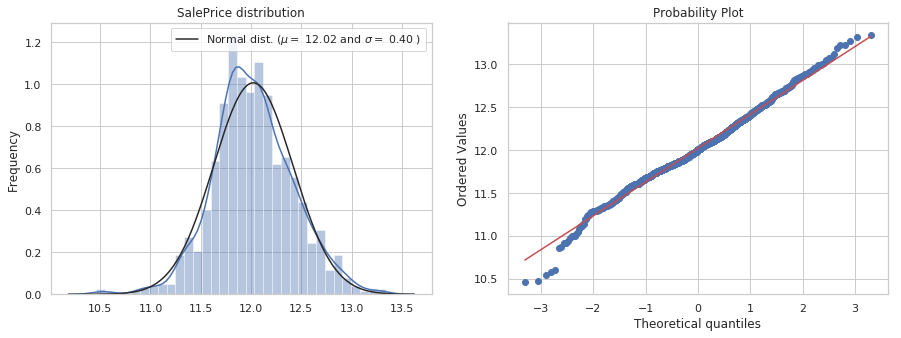

In [115]:
#We use the numpy fuction log1p which  applies ln(1+x) to all elements of the column
ln_y = np.log1p(y)

#Check the new distribution 
plt.figure(figsize=(15,5))
plt.subplot(121)
sns.distplot(ln_y , fit=norm)

# Get the fitted parameters used by the function
mu, sigma = norm.fit(ln_y)
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')
xtick_labels = ["{:.0f}".format(tick/1000)+'K' for tick in p.get_xticks()]
p.set_xticklabels(xtick_labels)

plt.subplot(122)
res = stats.probplot(ln_y, plot=plt)
plt.show()

* Data is more or less normally distributed now.

## Categorizing Features 
* Into **Numeric**, **Categorical**, **Drop**

'LandSlope':
train NaN-s: 0
test  NaN-s: 0

     train  test
Gtl   1382  1396
Mod     65    60
Sev     13     3


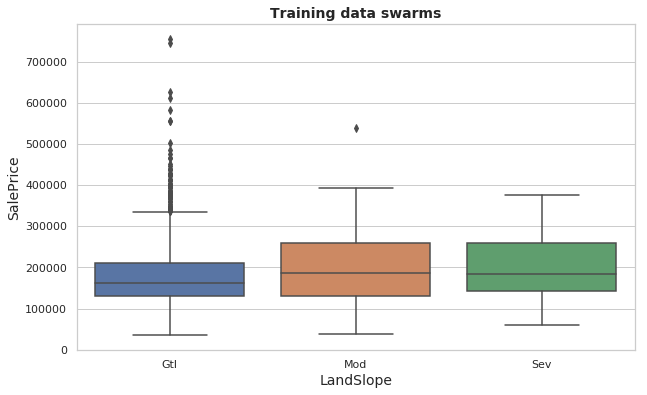

In [ ]:
# capturing discrete, continuous, and dropped features
discrete_fs, continuous_fs, drop_fs = discrete_or_continuous([train, test], 'SalePrice')

In [ ]:
cat_imp = ['MSSubClass', ]

ordinals = ['ExterQual', 'KitchenQual', 'ExterCond', 'HeatingQC', 'BsmtQual',
            'BsmtCond', 'GarageQual', 'FireplaceQu', 'GarageCond', 
            'BsmtExposure','BsmtFinType1', 'BsmtFinType2', 'GarageFinish']

extra_ordinals = ['LotShape', 'LandContour', 'LandSlope']

### Fine-Grouping

* Fine-grouping based on needed transformations

In [154]:
## CATEGORICAL ##

# needs (most_frequnt) imputation or no imputation
cat_mfimp = ['MSZoning', 'Street', 'LotShape', 'LandContour', 'LotConfig',
             'LandSlope', 'Neighborhood', 'Condition1', 'BldgType', 'OverallQual',
             'OverallCond', 'RoofStyle', 'ExterQual', 'ExterCond', 'Foundation',
             'HeatingQC', 'CentralAir', 'BsmtFullBath', 'BsmtHalfBath', 'HalfBath',
             'KitchenQual', 'Functional', 'PavedDrive', 'MoSold', 'YrSold', 'SaleType',
             'SaleCondition']

# needs remaping NaN-s to 'OTHER'
cat_nan_other = ['Alley', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
                 'BsmtFinType2', 'FireplaceQu', 'GarageType', 'GarageFinish', 
                 'GarageCond', 'Fence']

# needs remapping 150:120, 'RRNn':'Norm', 'RRAe':'Norm','RRAn':'Norm',
# '2.5Fin':'1.5Fin', 'Membran':'WdShngl', 'Roll':'CompShg','Metal':'CompShg',
# 'ClyTile':'CompShg', 'ImStucc':'CemntBd', 'Stone':'CemntBd', 'Other':'ImStucc',
# 'Floor':'Grav','OthW':'GasA', 'Mix':'FuseP', 'Ex':'Gd', np.nan:'None'
cat_remap = ['MSSubClass', 'Condition2', 'HouseStyle', 'RoofMatl', 'Heating', 'MasVnrType']

cat_mfimp_remap = ['Exterior1st', 'Electrical']
cat_mfimp_remap2 = ['Exterior2nd']

cat_nan_other_remap = ['GarageQual']

# needs downclassing to fewer classes
cat_downclass_2 = ['PoolArea', 'ScreenPorch']
cat_downclass_3 = ['KitchenAbvGr']
cat_downclass_4 = ['FullBath', 'Fireplaces', 'GarageCars']
cat_downclass_6 = ['BedroomAbvGr']

# needs rebinning, FullBath form 4 to 3 (4 classes), BedroomAbvGr 5:inf (6 classes)
# TotRmsAbvgrd [0, 3.1, 4, 5, 6, 7, 8, 9, 10, 11, np.inf]
cat_rebin_totrms = ['TotRmsAbvGrd']
cat_rebin_yrmod = ['YearRemodAdd']
cat_rebin_yrbuilt = ['YearBuilt']
cat_nan_0_rebin = ['GarageYrBlt']

# all categorical columns
all_cat = np.concatenate([cat_mfimp, cat_nan_other, cat_remap, cat_nan_other_remap,
                         cat_downclass_2, cat_downclass_3, cat_downclass_4, cat_downclass_6,
                         cat_rebin_totrms, cat_rebin_yrmod, cat_rebin_yrbuilt, cat_nan_0_rebin,
                         cat_mfimp_remap, cat_mfimp_remap2])
## CONTINUOUS ##

# needs imputing with mean or doing nothing
num_meanimp = ['LotArea', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea',
               'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch',
               '3SsnPorch', 'MiscVal']

# needs imputing NaN-s with 0s
num_nan_0 = ['LotFrontage', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
            'TotalBsmtSF']

all_num = np.concatenate([num_meanimp, num_nan_0])

#dropped_features = drop_fs + ['PoolQC', 'MiscFeature']

In [216]:
test_ct = ColumnTransformer(transformers=[
    ('cat_mfimp', DFImputer('most_frequent'), cat_mfimp)
], n_jobs=-1).fit(data)

test_data = test_ct.fit_transform(data)

In [217]:
test_data_names = np.concatenate([i[-1] for i in test_ct.transformers])
pd.DataFrame(test_data, index=data.index, columns=test_data_names).head()

,MSZoning,Street,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,BldgType,OverallQual,...,BsmtFullBath,BsmtHalfBath,HalfBath,KitchenQual,Functional,PavedDrive,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
1,RL,Pave,Reg,Lvl,Inside,Gtl,CollgCr,Norm,1Fam,7,...,1,0,1,Gd,Typ,Y,2,2008,WD,Normal
2,RL,Pave,Reg,Lvl,FR2,Gtl,Veenker,Feedr,1Fam,6,...,0,1,0,TA,Typ,Y,5,2007,WD,Normal
3,RL,Pave,IR1,Lvl,Inside,Gtl,CollgCr,Norm,1Fam,7,...,1,0,1,Gd,Typ,Y,9,2008,WD,Normal
4,RL,Pave,IR1,Lvl,Corner,Gtl,Crawfor,Norm,1Fam,7,...,1,0,0,Gd,Typ,Y,2,2006,WD,Abnorml
5,RL,Pave,IR1,Lvl,FR2,Gtl,NoRidge,Norm,1Fam,8,...,1,0,1,Gd,Typ,Y,12,2008,WD,Normal


## Transforming
* Transforming train & test data to be cross-compatible for the models
* Here we **impute**, **rebin** & **label_encode** the data

### Building Custom transformers

In [22]:
# imputes missing values by mean or specified value
class DFImputer(BaseEstimator, TransformerMixin):
    def __init__(self, fill_value='mean'):
        self.fill_value = fill_value
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        if self.fill_value == 'mean':
            return X.fillna(X.mean())
        elif self.fill_value == 'most_frequent':
            return X.fillna(X.mode().iloc[0])
        else:
            return X.fillna(self.fill_value)

In [23]:
# value remapper based on specified dictionary
class ValueRemapper(BaseEstimator, TransformerMixin):
    def __init__(self, remap_dict={}, vsrest_list=[]):
        self.remap_dict = remap_dict
        self.vsrest_list = vsrest_list
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        if len(self.vsrest_list) == 0:
            return X[X.columns].replace(to_replace=self.remap_dict)
        else:
            for col in X.columns:
                X[col] = X[col].apply(lambda x: x if x in self.vsrest_list else 'REST')
            return X

In [24]:
# reclassifies integer type features down to specified classes
# n_classes means binary classifier 0 and any other number to 1 etc...
class NumericReclassifier(BaseEstimator, TransformerMixin):
    def __init__(self, n_classes=2):
        self.n_classes = n_classes
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        return X.where(cond=X[X.columns] < self.n_classes - 1, other=self.n_classes - 1)

In [25]:
# rebins feature range uniformly if only bin quantity is given
# or based on given bin edges
class FeatureRebinner(BaseEstimator, TransformerMixin):
    def __init__(self, bin_edges):
        self.bin_edges = bin_edges
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):    
        labels = np.arange(0, len(self.bin_edges)-1)
        for col in X.columns:
            X[col] = pd.cut(x=X[col], bins=self.bin_edges, labels=labels, include_lowest=True)
        return X

In [26]:
# create interaction features and select only the specified ones
class FeatureInteractions(BaseEstimator, TransformerMixin):
    def __init__(self, interaction_names=None):
        self.interaction_names = interaction_names
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):    
        imped_df = X[X.columns].fillna(X[X.columns].mean())
        
        # generate all possible interaction names
        names = [col0+'_'+col1 for i,col0 in enumerate(imped_df) 
             for col1 in imped_df.columns[i+1:]]
        n_interactions = len(names) # determine number of interactions
        
        # generate numeric interactions
        interactions = PolynomialFeatures(degree=2, interaction_only=True) \
            .fit_transform(imped_df)[:,-n_interactions:]
        
        all_inters_df = pd.DataFrame(data=interactions, columns=names)
        
        if self.interaction_names is None:
                return all_inters_df
        else:
            return all_inters_df[self.interaction_names]

In [27]:
# encode ordianl categorical variables 
class OrdinalEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, ascend_cats):
        self.ascend_cats = ascend_cats
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):    
        cols = X.columns
        df = X[cols].astype('category')
        df = df.apply(lambda x: x.cat.reorder_categories(self.ascend_cats, ordered=True))
        return df.apply(lambda x: x.cat.codes)

In [28]:
# encode nominal categoricals
class NominalEncoder(BaseEstimator, TransformerMixin):
    def __init__(self):
        return None
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):    
        cols = X.columns
        return X[cols].apply(LabelEncoder().fit_transform)

In [29]:
# take a log(x + 1) of a skewed numeric features
class Unskewer(BaseEstimator, TransformerMixin):
    def __init__(self):
        return None
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        cols = X.columns
        X[cols].astype('float64', copy=False) 
        return X[cols].apply(np.log1p)

### Imputing, rebinning & re-ordering

1. Imputing missing values and rebinning some of the features
2. Reordering ordinal categorical variables

**EXTRA things to consider**:
* LotFrontage : Since the area of each street connected to the house property most likely have a similar area to other houses in its neighborhood , we can fill in missing values by the median LotFrontage of the neighborhood.



In [157]:
ct_imp = ColumnTransformer([
    ('cat_mfimp', SimpleImputer(strategy='most_frequent'), cat_mfimp),
    ('cat_nan_other', SimpleImputer(strategy='constant', fill_value='NA'), cat_nan_other),
    ('cat_remap', ValueRemapper({150:120, 'RRNn':'Norm', 'RRAe':'Norm',
        'RRAn':'Norm', '2.5Fin':'1.5Fin', 'Membran':'WdShngl', 'Roll':'CompShg',
        'Metal':'CompShg','ClyTile':'CompShg','Floor':'Grav',
        'OthW':'GasA', np.nan:'None'}), cat_remap),
    ('cat_mfimp_remap', Pipeline([
        ('imp', DFImputer(fill_value='most_frequent')),
        ('remap', ValueRemapper({'ImStucc':'CemntBd', 'Stone':'CemntBd', 
                                 'Mix':'FuseP', 'Other':'ImStucc'}))
    ]), cat_mfimp_remap),
    ('cat_mfimp_remap2', Pipeline([
        ('imp', DFImputer(fill_value='most_frequent')),
        ('remap', ValueRemapper({'Other':'ImStucc'}))
    ]), cat_mfimp_remap2),
    ('cat_nan_other_remap', Pipeline([
        ('nan_other', DFImputer(fill_value='NA')),
        ('remap', ValueRemapper({'Ex':'Gd'}))
    ]), cat_nan_other_remap),
    ('cat_downclass_2', NumericReclassifier(2), cat_downclass_2),
    ('cat_downclass_3', NumericReclassifier(3), cat_downclass_3),
    ('cat_downclass_4', NumericReclassifier(4), cat_downclass_4),
    ('cat_downclass_6', NumericReclassifier(6), cat_downclass_6),
    ('cat_rebin_year', FeatureRebinner(np.concatenate([[1800], np.arange(1920,2001,5),
        np.arange(2001,2011)])), cat_rebin_yrbuilt),
    ('cat_rebin_yrmod', FeatureRebinner(np.concatenate([np.arange(1950,2001,5),
        np.arange(2001,2011)])), cat_rebin_yrmod),
    ('cat_rebin_totrms', FeatureRebinner([0, 4, 5, 6, 7, 8, 9, 10, 11, np.inf]), 
        cat_rebin_totrms),
    ('cat_nan_0_rebin', Pipeline([
        ('nan0', DFImputer(fill_value=0)),
        ('remap', ValueRemapper({2207:2007})),
        ('rebin', FeatureRebinner(np.concatenate([[-1], [1890], np.arange(1920,2001,5),
            np.arange(2001,2011)])))
    ]), cat_nan_0_rebin),
    ('num_meanimp', DFImputer(fill_value='mean'), num_meanimp),
    ('num_nan_0', DFImputer(fill_value=0), num_nan_0)
]).fit(train_out)

# extracting column names from the ct1 object
names_imp = np.concatenate([i[-1] for i in ct_imp.transformers])

train_clean = pd.DataFrame(ct_imp.fit_transform(train_out), columns=names_imp).infer_objects()
test_clean = pd.DataFrame(ct_imp.fit_transform(test), columns=names_imp).infer_objects()

assert_dfs(train_clean, test_clean)

Train shape: (1456, 76)
Test shape: (1459, 76)


### Encoding, Log-ing, Scaling
1. Encoding ordinal categoricals to **ordered** numeric labels
2. Encoding nominal categoricals to numeric labels
3. Log(x+1) transforming skewed numeric features
4. Scaling remaining numeric features

In [158]:
# select ordinal categoricals
ordinals = ['ExterQual', 'KitchenQual', 'ExterCond', 'HeatingQC', 'BsmtQual',
            'BsmtCond', 'GarageQual', 'FireplaceQu', 'GarageCond', 
            'BsmtExposure','BsmtFinType1', 'BsmtFinType2', 'GarageFinish']

# find nominal categoricals
nominals = list(set(all_cat).difference(ordinals))

In [159]:
# computing the skewness of a numeric feature
skewness = train_clean[all_num].apply(lambda x: stats.skew(x.dropna()))

# outputing features that has skewness more than 75%
top_skews = skewness[skewness > 0.75]
skewed_features = top_skews.index.values
skewed_features

array(['LotArea', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea',
       'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
       'MiscVal', 'MasVnrArea', 'BsmtFinSF2', 'BsmtUnfSF'], dtype=object)

In [160]:
# numeric fetaures to be scaled
scalers = list(set(all_num).difference(skewed_features))

# check if all the features are captured
len(ordinals) + len(nominals) + len(skewed_features) + len(scalers) == 76

True

In [161]:
ct_ord = ColumnTransformer([
    ('ordi1', OrdinalEncoder(['Fa', 'TA', 'Gd', 'Ex']), ['ExterQual', 'KitchenQual']),
    ('ordi2', OrdinalEncoder(['Po', 'Fa', 'TA', 'Gd', 'Ex']), 
        ['ExterCond', 'HeatingQC']),
    ('ordi3', OrdinalEncoder(['NA', 'Fa', 'TA', 'Gd', 'Ex']), ['BsmtQual']),
    ('ordi4', OrdinalEncoder(['NA', 'Po', 'Fa', 'TA', 'Gd']), 
        ['BsmtCond', 'GarageQual']),
    ('ordi5', OrdinalEncoder(['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex']), 
        ['FireplaceQu', 'GarageCond']),
    ('ordi6', OrdinalEncoder(['NA', 'No', 'Mn', 'Av', 'Gd']), ['BsmtExposure']),
    ('ordi7', OrdinalEncoder(['NA', 'Unf','LwQ','Rec','BLQ','ALQ','GLQ']), 
        ['BsmtFinType1', 'BsmtFinType2']),
    ('ordi8', OrdinalEncoder(['NA', 'Unf', 'RFn', 'Fin']), ['GarageFinish']),
    ('nominals', NominalEncoder(), nominals),
    ('unskew', Unskewer(), skewed_features),
    ('scale', StandardScaler(), scalers)
]).fit(train_clean)

# extracting column names from the ct object
names_ord = np.concatenate([i[-1] for i in ct_ord.transformers])

train_clean[names_ord] = ct_ord.fit_transform(train_clean)
test_clean[names_ord] = ct_ord.fit_transform(test_clean)

assert_dfs(train_clean, test_clean)

Train shape: (1456, 76)
Test shape: (1459, 76)


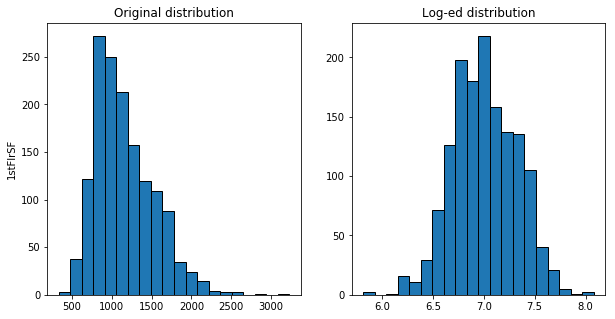

In [35]:
# plotting original vs variable log-ed feature distribution
plt.figure(figsize=(10, 5))
plt.subplot(121)
train_out['1stFlrSF'].hist(grid=False, ec='k', bins=20)
plt.title('Original distribution')
plt.ylabel('1stFlrSF')
plt.subplot(122)
train_clean['1stFlrSF'].hist(grid=False, ec='k', bins=20)
plt.title('Log-ed distribution')
plt.show()

## Feature Engineering

### Sums of features

In [162]:
## NUMERIC FEATURES ##

# total surface area of the house (basement added)
train_clean["AllSF"] = train_clean["GrLivArea"] + train_clean["TotalBsmtSF"]
test_clean["AllSF"] = test_clean["GrLivArea"] + test_clean["TotalBsmtSF"]

# total surface area above basement
train_clean["AllFlrsSF"] = train_clean["1stFlrSF"] + train_clean["2ndFlrSF"]
test_clean["AllFlrsSF"] = test_clean["1stFlrSF"] + test_clean["2ndFlrSF"]

# total number of bathrooms
all_bathrooms = ['BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath']
train_clean["TotalBath"] = train_clean[all_bathrooms].sum(axis='columns')
test_clean["TotalBath"] = test_clean[all_bathrooms].sum(axis='columns')

# total number of rooms
train_clean['TotalRms'] = train_clean['TotRmsAbvGrd'] + train_clean['TotalBath']
test_clean['TotalRms'] = test_clean['TotRmsAbvGrd'] + test_clean['TotalBath']

new_nums = ["AllSF", "AllFlrsSF", "TotalBath", 'TotalRms']

assert_dfs(train_clean, test_clean)

Train shape: (1456, 80)
Test shape: (1459, 80)


### Correlated features
* Let's see how top features correlate relative to the target based on Pearson $r$

In [37]:
train_clean2 = train_clean.copy()
train_clean2['SalePrice'] = np.log1p(train_out.SalePrice.values)

# produce correlation df (matrix)
corrs = train_clean2.corr()
corrs.sort_values(['SalePrice'], axis=0, ascending=False, inplace=True)
corrs[corrs['SalePrice'] > 0.6]['SalePrice'].round(3)

SalePrice       1.000
OverallQual     0.819
AllSF           0.752
GrLivArea       0.733
GarageCars      0.686
ExterQual       0.681
KitchenQual     0.667
TotalRms        0.664
TotalBath       0.656
GarageArea      0.655
BsmtQual        0.647
TotalBsmtSF     0.642
YearBuilt       0.621
GarageYrBlt     0.618
1stFlrSF        0.611
GarageFinish    0.605
Name: SalePrice, dtype: float64

### Polynomial Features
* Generate all possible polynomial features for trainig and testing sets based on provided columns
* Extract top X polynomial features

In [38]:
# return top X numeric polynomial features based on estimator feature importances
def train_poly_df(X, y, num_columns, top_fi=10, 
                        estimator=RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=7)):
    '''Generate polynomial features and return top features based
    on specified estimator feature importances.
    
    Parameters
    ----------
    X : dataframe
    
    y : series, list
    
    num_columns : list
        List of numeric column names.
    
    estimator : sklearn estimator
        Has to have feature_importances_ attribute.
    
    top_fi : int
        Top polynomial features to be considered.
        
    Returns : DF'''
    
    poly = PolynomialFeatures(include_bias=False).fit(X[num_columns])
    poly_names = poly.get_feature_names(X[num_columns].columns)
    X_poly = pd.DataFrame(poly.transform(X[num_columns]), columns=poly_names)
    
    estimator.fit(X_poly, y)
    
    assert hasattr(estimator, 'feature_importances_'), "Estimator does NOT have a \
    'feature_importances_' attribute."
    
    X_fi = pd.DataFrame(estimator.feature_importances_, index=poly_names, columns=['fi']).sort_values(
        by='fi', ascending=False)
    
    # top_fi column names
    if top_fi == None:
        return X_poly
    top_fi_names = list(X_fi.iloc[:top_fi,:].index)
    return X_poly[top_fi_names]

In [39]:
# return top X polynomial features based on training set result
def test_poly_df(X, num_columns, train_poly_names):
    '''Return test set polynomial features based on training set
    feature importances result. 
    
    Parameters
    ----------
    X : Test set DF.
    
    num_columns : list of numeric column names.
    
    train_poly_names : Names of the polynomial features 
        acquired from the training set'''
    poly = PolynomialFeatures(include_bias=False).fit(X[num_columns])
    test_poly_names = poly.get_feature_names(X[num_columns].columns)
    X_poly = pd.DataFrame(poly.transform(X[num_columns]), columns=test_poly_names)
    
    return X_poly[train_poly_names]

In [163]:
# select all numeric columns
all_nums = np.c_[[all_num], [new_nums]].flatten()
all_feat = np.c_[[all_num], [new_nums], [all_cat]].flatten()

# return top X polynomial DFs
train_polys = train_poly_df(train_clean, ln_y, all_num, top_fi=10)
test_polys = test_poly_df(test_clean, all_num, train_polys.columns)

assert_dfs(train_polys, test_polys)

Train shape: (1456, 10)
Test shape: (1459, 10)


In [164]:
# adding top X polynomials to the data
train_fe = pd.concat([train_clean, train_polys.drop('GrLivArea', axis='columns')], axis='columns')
test_fe = pd.concat([test_clean, test_polys.drop('GrLivArea', axis='columns')], axis='columns')

assert_dfs(train_fe, test_fe)

Train shape: (1456, 89)
Test shape: (1459, 89)


# Feature Selection
* Try different methods to detect important features

## Univariate Statistics
* Each feature is **individually** used on target data. 
* Highest confidences are selected (based on some threshold)
* In *sklearn* a **test type** and **method** must be chosen to discard features:
    * **f_regression** for *regression*
* Method: **p-values** (measure (probability) of the strength <font color='red'>**AGAINST**</font> 0-hypothesis) provided by the test. If our null-hypothesis states '*feature has no effect on target*' and we obtain small p-value (0.003) it would suggest that we should keep the feature since the probability of the siginificance of the feature being that high purely on chance is 0.3%. More than 3 std away from the mean. 
* Threshold can be set by:
    * Number of features to keep **SelectkBest**
    * Fraction of features to keep **SelectPercentile**

In [47]:
# select 'k' best features
f_selector = SelectKBest(score_func=f_regression, k=15).fit(train_fe, ln_y)

# see which features were selected with "get_support" method
mask = f_selector.get_support()
univ_features = train_fe.columns[mask]

# capture the selected data
train_univ = train_fe[univ_features]
test_univ = test_fe[univ_features]

In [48]:
univ_features

Index(['OverallQual', 'ExterQual', 'KitchenQual', 'BsmtQual', 'GarageCars',
       'GrLivArea', 'GarageArea', 'AllSF', 'TotalBath', 'TotalRms',
       '1stFlrSF GrLivArea', 'GrLivArea^2', '1stFlrSF GarageArea',
       'LotArea GrLivArea', 'GrLivArea GarageArea'],
      dtype='object')

## Recursive Feature Elimination
* The Recursive Feature Elimination (or RFE) works by recursively removing features and building a model on those features that remain.
* It uses the model score to identify which attributes (and combination of attributes) contribute the most to predicting the target attribute.

In [49]:
estimator = RandomForestRegressor(n_estimators=50, max_depth=8)
rfe = RFE(estimator, 15, 2).fit(train_fe, ln_y)
rfe_features = train_fe.columns[rfe.support_]
rfe_features

Index(['MSZoning', 'OverallQual', 'OverallCond', 'CentralAir', 'YearBuilt',
       'YearRemodAdd', 'BsmtFinSF1', 'AllSF', 'TotalBath',
       '1stFlrSF GrLivArea', 'GrLivArea^2', 'GarageArea TotalBsmtSF',
       'GarageArea BsmtUnfSF', 'LotArea GrLivArea', 'GrLivArea GarageArea'],
      dtype='object')

## Tree-based Feature Importances

In [715]:
# return important features DF
def important_features(cleaned_df, y,
                       estimator=RandomForestRegressor(n_estimators=100,max_depth=12, 
                                   n_jobs=-1, min_samples_split=4,min_samples_leaf=3)):    
    """Return DF of top X features."""
    estimator.fit(cleaned_df, y)
    X_fi = pd.DataFrame(estimator.feature_importances_, index=cleaned_df.columns, 
                        columns=['fi']).sort_values(by='fi', ascending=False)
    #list(X_fi.iloc[:top_fi,:].index)
    return X_fi 

In [716]:
# df of sorted feature importances
feat_imps_lny_df = important_features(train_scaled, ln_y)

# Postprocessing
* After most important/best features are selected nominal features should be OneHotEncoded

In [165]:
ct_ohe = ColumnTransformer([
    ('ohe', OneHotEncoder(categories='auto'), nominals)
], remainder='passthrough')

train_ohe = ct_ohe.fit_transform(train_fe)
test_ohe = ct_ohe.fit_transform(test_fe)

# Models

## Model Performance Functions

* When we already log trasnformed target ourselves we do not need to use root mean squre log error but just **root mean squared error**

In [51]:
# function to test model performance
def test_a_model(estimator, X, y):
    cv_scores = -cross_val_score(estimator, X=X, y=y,scoring='neg_mean_squared_error', cv=5)
    print('{} RMSLE {:.5f} (+/- {:.5f})'.format(estimator.__class__.__name__, 
                                                np.sqrt(cv_scores).mean(), 
                                                np.sqrt(cv_scores).std()))

In [52]:
# function for hyperparameter tuning. Outputs best
# accuracy at best parameters
def tune_hyper(estimator, param_grid, X, y, cv=5, n_jobs=-1):
    grid = GridSearchCV(estimator, param_grid, cv=cv, iid=False, 
                        scoring='neg_mean_squared_error',
                        return_train_score=False, n_jobs=-1).fit(X=X, y=y)
    
    print('{} Best rmsle score: {:.5f}'.format(estimator.__class__.__name__, np.sqrt(-grid.best_score_)))
    print('Best parameters: {}'.format(grid.best_params_))
    
    if len(grid.param_grid) == 1:
        param_name = list(grid.param_grid.keys())[0]
        grid_df = pd.DataFrame(grid.cv_results_)
        grid_df['mean_test_score'] = np.sqrt(-grid_df['mean_test_score'])
        plot_df = grid_df[['param_'+param_name, 'mean_test_score']]
        ds = ColumnDataSource(plot_df)
        
        p = figure(plot_width=600, plot_height=400)
        p.line('param_'+param_name, 'mean_test_score', source=ds, line_width=2)
        p.circle('param_'+param_name, 'mean_test_score', source=ds, size=10, 
                 line_color='black', line_width=2, hover_fill_color='red')
        p.title.text = grid.estimator.__class__.__name__ + ' GridSearchCV'
        p.xaxis.axis_label = param_name
        p.yaxis.axis_label = 'RMSE'
        p.yaxis.major_label_orientation = 'horizontal'
        hover = HoverTool(tooltips=[("RMSE", '@mean_test_score'), 
                            ("{}".format(param_name), "@param_"+param_name)])
        p.add_tools(hover, BoxSelectTool())
        show(p)
    
    return grid.best_estimator_

## Regularized Linear Models

### Ridge
* Main tuning paramter is reluarization coefficent $\alpha$, whcih restricts feature

In [53]:
ridge = tune_hyper(Ridge(random_state=7), {'alpha':np.arange(10,40)}, train_fe, ln_y)

Ridge Best rmsle score: 0.11887
Best parameters: {'alpha': 30}


In [54]:
# trying out if categorical data is OneHotEncoded
test_a_model(Ridge(alpha=30), train_ohe, ln_y)

Ridge RMSLE 0.12582 (+/- 0.00402)


In [322]:
preds_to_csv(Ridge(alpha=30, random_state=7), train_fe, test_fe, ln_y, log_y=True)

DF shape: (1459, 2)
price_predictions_48.csv file created.


Scored 0.12403

### Lasso

In [56]:
lasso = tune_hyper(Lasso(max_iter=5000), {'alpha': np.logspace(-4, -3, 10)}, train_fe, ln_y)

Lasso Best rmsle score: 0.11855
Best parameters: {'alpha': 0.000774263682681127}


In [64]:
lasso_df = pd.DataFrame({'coef':lasso.coef_, 'feature':train_fe.columns}). \
    sort_values('coef', ascending=False).reset_index(drop=True)
lasso_df['influence'] = lasso_df['coef'].apply(lambda x: 'positive' if  x>0 else 'negative')
print('Lasso chose {}/{} fetaures'.format((lasso_df['coef'] != 0).sum(),
                                          lasso_df.shape[0]))

Lasso chose 70/89 fetaures


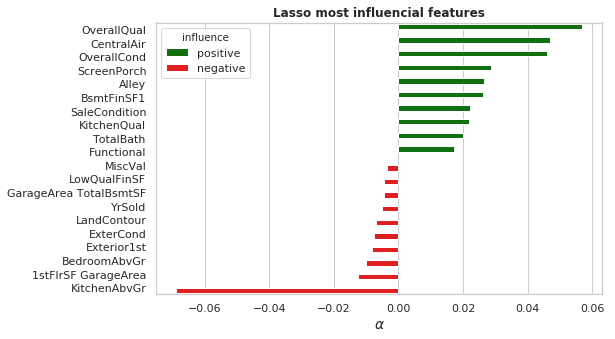

In [65]:
sns.set(style='whitegrid')

plt.figure(figsize=(8,5))
top_bottom_coefs = pd.concat([lasso_df.head(10), lasso_df.tail(10)], ignore_index=True)
sns.barplot(x='coef', y='feature', hue='influence', 
            data=top_bottom_coefs, palette=['green', 'red'])

plt.title('Lasso most influencial features', weight='bold')
plt.xlabel(r'$\alpha$', size=14)
plt.ylabel('')
plt.show()

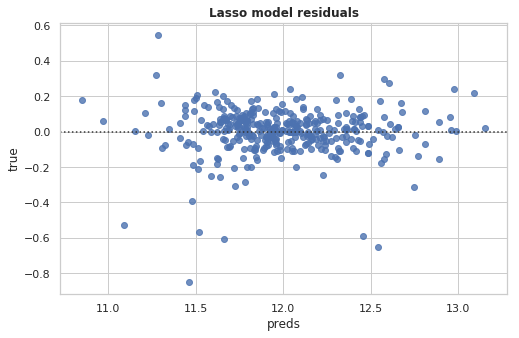

In [66]:
Xtrain, Xtest, ytrain, ytest = train_test_split(train_fe, ln_y)

# chcking residuals
lasso2 = lasso.fit(Xtrain, ytrain)
preds_df = pd.DataFrame({'preds':lasso2.predict(Xtest), 'true':ytest})
plt.figure(figsize=(8,5))
sns.residplot('preds', 'true', data=preds_df)
plt.title('Lasso model residuals', weight='bold')
plt.show()

* If the residuals are scattered uniformly above and below true 0 value the better the model predicts on average on each data point.
* This plot seems quite decent

In [324]:
preds_to_csv(Lasso(alpha=0.000774, max_iter=5000), train_fe, test_fe, ln_y, log_y=True)

DF shape: (1459, 2)
price_predictions_50.csv file created.


In [59]:
lasso_ohe = tune_hyper(Lasso(max_iter=500), {'alpha':np.logspace(-4, 3, 10)},
                       train_ohe, ln_y)

Lasso Best rmsle score: 0.11331
Best parameters: {'alpha': 0.0005994842503189409}


In [61]:
# testing OHE
test_a_model(Lasso(alpha=0.0006, max_iter=5000), train_ohe, ln_y)

/home/tonu_ilves/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.02569112830458664, tolerance: 0.018559329752026
  max_iter, tol, rng, random, positive)


Lasso RMSLE 0.11329 (+/- 0.00436)


In [62]:
preds_to_csv(Lasso(alpha=0.0006, max_iter=5000), train_ohe, test_ohe, ln_y, True)

DF shape: (1459, 2)
price_predictions_53.csv file created.


Scored 0.13520

Scored 0.12349

### ElasticNet

In [393]:
elasticnet = tune_hyper(ElasticNet(alpha=9e-4, max_iter=5000),
                        {'l1_ratio':np.arange(0.5, 1, 0.05)}, train_fe, ln_y)

ElasticNet Best rmsle score: 0.11854
Best parameters: {'l1_ratio': 0.7500000000000002}


### xgboost

* optimized distributed gradient boosting library
* implements machine learning algorithms under the Gradient Boosting framework

In [63]:
#checking if there are any duplicate columns
u, c = np.unique(train_fe.columns, return_counts=True)
dup = u[c > 1]
dup

array([], dtype=object)

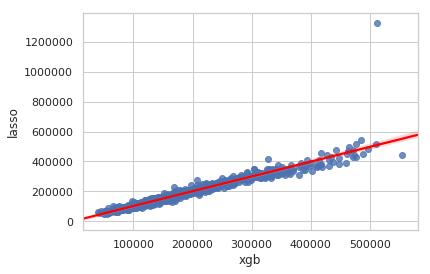

In [82]:
xgbreg = xgboost.XGBRegressor(n_estimators=300).fit(train_fe, ln_y)
lasso2 = Lasso(alpha=0.000774, max_iter=5000).fit(train_fe, ln_y)

xgb_preds = np.expm1(xgbreg.predict(test_fe))
lasso_preds = np.expm1(lasso2.predict(test_fe))

predictions = pd.DataFrame({"xgb":xgb_preds, "lasso":lasso_preds})
sns.regplot('xgb', 'lasso', predictions, line_kws={"color": "red"})
plt.show()

In [81]:
rfr = RandomForestRegressor(n_estimators=100, n_jobs=-1).fit(
    predictions[['xgb', 'lasso']], predictions['true'])

rfr.feature_importances_

array([0.42249115, 0.57750885])

In [83]:
xgb_lasso_preds = 0.58*lasso_preds + 0.42*xgb_preds

solution = pd.DataFrame({"id":test.Id, "SalePrice":xgb_lasso_preds})
solution.to_csv("data/iowa_house_prices/submissions/price_predictions_55.csv", index = False)

## SVMs

### LinearSVR

In [374]:
linearsvr = tune_hyper(LinearSVR(max_iter=5000, tol=0.001), {'epsilon':[0.01, 0.1, 0.02],
                         'C': [0.05, 0.1, 0.5]}, train_fe, ln_y)

LinearSVR Best rmsle score: 0.12596
Best parameters: {'C': 0.1, 'epsilon': 0.1}


/home/tonu_ilves/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


## Trying Stacking Method

* **cross_val_score** doesn't have a shuffle attribute, which could provde better sample selection, therefore we use **KFold** that shuffles the data

In [172]:
#Shuffled validation function
n_folds = 5
def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=17).get_n_splits(train_fe.values)
    rmse= np.sqrt(-cross_val_score(model, train_ohe.toarray(), ln_y, 
                                   scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

### Building Base Models

**Lasso**

In [173]:
#function returns best model parameters
lasso_ohe = tune_hyper(Lasso(max_iter=500), {'alpha':np.logspace(-5, -3, 10)},
                       train_ohe, ln_y)

Lasso Best rmsle score: 0.11331
Best parameters: {'alpha': 0.0005994842503189409}


**ElasticNet**

In [130]:
enet_ohe = tune_hyper(ElasticNet(), {'alpha':[0.0006], 
                                     'l1_ratio':[0.85, 0.9, 0.95]},train_ohe, ln_y)

ElasticNet Best rmsle score: 0.11332
Best parameters: {'alpha': 0.0006, 'l1_ratio': 0.95}


/home/tonu_ilves/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.11330545917506107, tolerance: 0.022825630709970138
  max_iter, tol, rng, random, positive)


**Kernel Ridge**

In [133]:
ridge_ohe = tune_hyper(KernelRidge(kernel='polynomial', degree=1), {'alpha':np.logspace(-3,-1,10)},
                      train_ohe, ln_y)

KernelRidge Best rmsle score: 0.11731
Best parameters: {'alpha': 0.021544346900318832}


**Gradient Boosting Regressor** - huber loss makes it robust to outliers

In [134]:
gboostreg_ohe = tune_hyper(GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5), {}, train_ohe, ln_y)

GradientBoostingRegressor Best rmsle score: 0.11873
Best parameters: {}


**XGBoost**

In [135]:
xgb_ohe = tune_hyper(xgboost.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =17, nthread = -1), {}, train_ohe, ln_y)

XGBRegressor Best rmsle score: 0.11869
Best parameters: {}


**LightGBM**

In [137]:
lightgbm_ohe = tune_hyper(lightgbm.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11), {}, train_ohe, ln_y)

LGBMRegressor Best rmsle score: 0.12140
Best parameters: {}


### Stacking the models

**Averaging predictions**

In [138]:
# stacking models and averageing their results
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    # we define clones of the original models to fit the data in
    # clones are deep copies of a model parameters which is not fitted yet
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self
    
    #Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1)   

In [141]:
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn #ignore annoying warning (from sklearn and seaborn)

In [177]:
averaged_models = AveragingModels(models = [lasso_ohe, enet_ohe, 
                                            ridge_ohe, gboostreg_ohe]).fit(train_ohe,ln_y)
mean_stack_score = rmsle_cv(averaged_models)
print('Averaged Stack RMSE: {:.4f}'.format(mean_stack_score.mean()))

Averaged Stack RMSE: 0.1115


In [178]:
preds_to_csv(averaged_models, train_ohe, test_ohe, ln_y, True)

DF shape: (1459, 2)
price_predictions_56.csv file created.
